# **Qualitative Analysis and Model Selection**

In this notebook we conduct an evaluation of the different models tested in this project.

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

In [7]:
RESULTS_PATH = Path("results")

xgb_results = pd.read_csv(RESULTS_PATH / "xgb_evaluation_metrics.csv")
lstm_base_results = pd.read_csv(RESULTS_PATH / "lstm_results_base.csv")
lstm_graph_results = pd.read_csv(RESULTS_PATH / "lstm_results_graph.csv")
lstm_embedding_results = pd.read_csv(RESULTS_PATH / "lstm_results_graph_embedding.csv")

xgb_results['Model'] = xgb_results['Dataset'].apply(lambda x: f"XGBoost {x}")
lstm_base_results['Model'] = "LSTM Base"
lstm_graph_results['Model'] = "LSTM Graph Features"
lstm_embedding_results['Model'] = "LSTM Embedding"

In [8]:
xgb_results = xgb_results[['Model', 'MAE', 'RMSE', 'R²']]
lstm_results = pd.concat([lstm_base_results, lstm_graph_results, lstm_embedding_results], ignore_index=True)
all_results = pd.concat([xgb_results, lstm_results], ignore_index=True)

all_results = all_results.sort_values(by="RMSE").reset_index(drop=True)

In [9]:
print("Results:")
display(all_results)

Results:


,Model,MAE,RMSE,R²,Dataset
0,XGBoost Base,0.177592,1.874649,0.941134,NaN
1,XGBoost Graph,0.215033,1.920100,0.938245,NaN
2,LSTM Embedding,1.354817,2.631990,0.893841,NaN
3,LSTM Base,1.404445,2.750462,0.884069,Base
4,LSTM Graph Features,1.382264,2.784200,0.880951,Graph


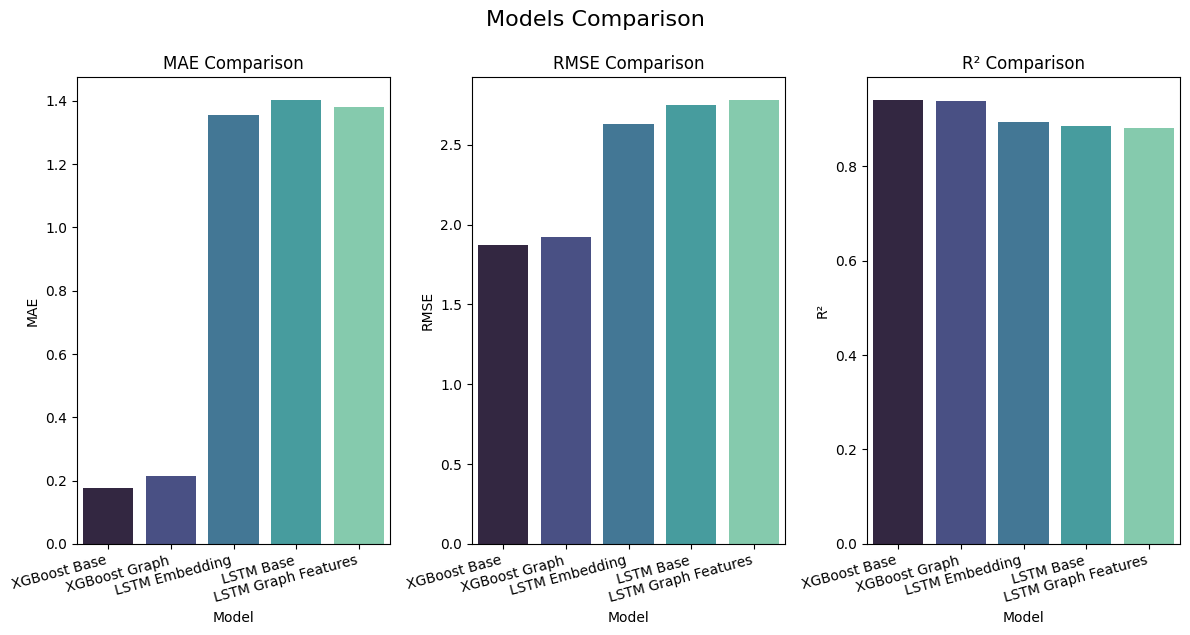

In [12]:
plt.figure(figsize=(12, 6))
metrics = ["MAE", "RMSE", "R²"]

for i, metric in enumerate(metrics):
    plt.subplot(1, 3, i+1)
    sns.barplot(
        data=all_results, 
        x="Model", y=metric, 
        hue = "Model",
        legend=False,
        palette="mako")
    plt.xticks(rotation=15, ha='right')
    plt.title(f"{metric} Comparison")
    plt.tight_layout()

plt.suptitle("Models Comparison", fontsize=16, y=1.05)
plt.show()

In [14]:
best_model = all_results.iloc[0]
print(f"Best RMSE model: {best_model['Model']} - RMSE: {best_model['RMSE']:.4f}")


Best RMSE model: XGBoost Base - RMSE: 1.8746


#### **Summary of Experimental Findings**
We compared the following models:
- **XGBoost (Base):** Trained on the dataset without graph-derived features.
- **XGBoost (Graph):** Trained on the dataset enriched with graph-based features extracted from the railway network structure.
- **LSTM (Base):** Trained on sequential data, exploiting temporal dependencies.
- **LSTM (Graph Features):** Same as Base, with additional graph features.
- **LSTM (Graph Embedding):** Trained using graph embeddings obtained via Node2Vec.

The evaluation metrics (MAE, RMSE, R^2) clearly indicated that:
- XGBoost models achieved the best predictive performance, with lower RMSE and higher R^2.
- The improvement brought by the graph features was marginal and did not significantly change the performance.
- LSTM models generally underperformed compared to XGBoost, but among them, the LSTM model trained on graph embeddings outperformed all other LSTM variants.

This suggests that the structural information encoded in the graph embeddings was more useful than the handcrafted graph-based features, likely because the embeddings capture latent relationships between stations that are not explicitly represented in the dataset. However, despite this improvement, even the best-performing LSTM was unable to surpass the performance of XGBoost, reinforcing the idea that sequential modeling is not necessarily the optimal approach for this task.

#### **Theoretical Considerations and Model Selection**

The choice of the final model is not solely based on the numerical results, but also on theoretical principles of machine learning:

**Occam's Razor Principle**

According to the principle of Occam’s Razor, the simplest model that sufficiently explains the data should be preferred.  
In our case, XGBoost, a gradient-boosted decision tree model, achieves excellent results without requiring complex architectures or sequential modeling.  
LSTM networks, although powerful and capable of capturing temporal dependencies, add unnecessary complexity without a meaningful improvement in accuracy.

**Bias-Variance Tradeoff**

LSTM models, due to their higher capacity and sequential nature, are prone to higher variance and risk of overfitting, especially when applied to datasets where temporal dependencies may not be the dominant factor affecting the target variable.  
On the contrary, XGBoost achieves a better balance between bias and variance, offering high predictive power without the risk of overfitting observed in deep learning models.
That said, the LSTM trained on graph embeddings showed reduced variance compared to other LSTM models, suggesting that the embeddings provided a useful regularization effect. Still, its variance remained higher than that of XGBoost.

**Interpretability and Scalability**

XGBoost models are easier to interpret and explain compared to neural networks. In an operational environment (such as the railway system), the ability to justify predictions is crucial.  
Additionally, XGBoost supports GPU acceleration and scales efficiently to large datasets, making it well-suited for real-time applications.


**Final Decision**

Considering both quantitative results and theoretical arguments, we conclude that the XGBoost model trained on the base dataset is the most appropriate choice for this task.  
It offers a good balance between accuracy, simplicity, scalability, and interpretability, all key aspects for a reliable and operationally usable prediction model.

That said, the success of graph embeddings in the LSTM model suggests that incorporating these embeddings into XGBoost might be a promising avenue for future improvements.


## **Final Decision Update**

The last reflection in the previous section led us to conduct a new experiment before proceeding. In fact, we included the XGBoost model trained on the dataset containing graph embeddings alongside the previously tested models. 

In [19]:
RESULTS_PATH = Path("results")

xgb_results = pd.read_csv(RESULTS_PATH / "xgb_evaluation_metrics.csv")
xgb_embeddings_results = pd.read_csv(RESULTS_PATH / "xgb_embedding_evaluation_metrics.csv")

xgb_results['Model'] = xgb_results['Dataset'].apply(lambda x: f"XGBoost {x}")
xgb_embeddings_results['Model'] = "XGBoost Embeddings"
xgb_embeddings_results['Dataset'] = "Base + Embeddings"

In [20]:
xgb_results = pd.concat([xgb_results, xgb_embeddings_results], ignore_index=True)

In [21]:
print("Results:")
display(xgb_results)

Results:


,Dataset,MAE,RMSE,R²,Model
0,Base,0.177592,1.874649,0.941134,XGBoost Base
1,Graph,0.215033,1.920100,0.938245,XGBoost Graph
2,Base + Embeddings,0.173286,1.671547,0.953198,XGBoost Embeddings


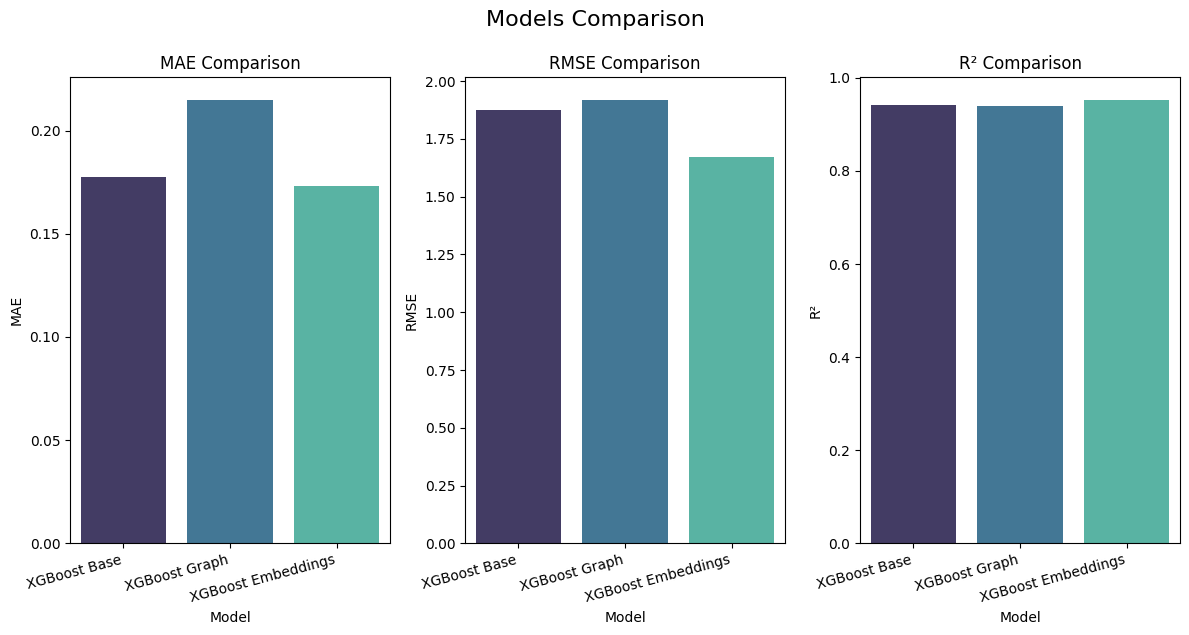

In [17]:
plt.figure(figsize=(12, 6))
metrics = ["MAE", "RMSE", "R²"]

for i, metric in enumerate(metrics):
    plt.subplot(1, 3, i+1)
    sns.barplot(
        data=xgb_results, 
        x="Model", y=metric, 
        hue = "Model",
        legend=False,
        palette="mako")
    plt.xticks(rotation=15, ha='right')
    plt.title(f"{metric} Comparison")
    plt.tight_layout()

plt.suptitle("Models Comparison", fontsize=16, y=1.05)
plt.show()


As we can see, these results clearly surpass the performance of both the XGBoost model trained on the base dataset and the one using handcrafted graph features, as well as all LSTM-based models evaluated. The significant reduction in prediction error and the high R^2 score indicate that the integration of graph embeddings allowed the model to better capture complex relationships in the data.

Based on these results, we select the XGBoost model with graph embeddings as our final model.